Import Dependencies

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import pandas as pd
import pathlib, datetime

---
# 1.Data Preparation module




Download and Load the data

The image collection contains 2000 natural scene images.

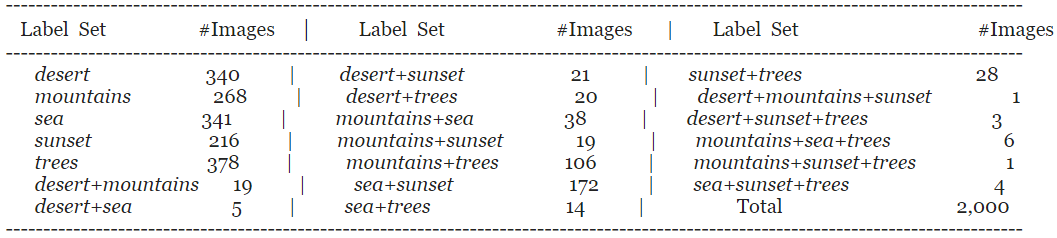

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd/content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


Unzip Dataset

In [ ]:
!unzip 'miml_dataset.zip'

Archive:  miml_dataset.zip
   creating: miml_dataset/
   creating: miml_dataset/images/
  inflating: miml_dataset/images/1.jpg  
  inflating: miml_dataset/images/10.jpg  
  inflating: miml_dataset/images/100.jpg  
  inflating: miml_dataset/images/1000.jpg  
  inflating: miml_dataset/images/1001.jpg  
  inflating: miml_dataset/images/1002.jpg  
  inflating: miml_dataset/images/1003.jpg  
  inflating: miml_dataset/images/1004.jpg  
  inflating: miml_dataset/images/1005.jpg  
  inflating: miml_dataset/images/1006.jpg  
  inflating: miml_dataset/images/1007.jpg  
  inflating: miml_dataset/images/1008.jpg  
  inflating: miml_dataset/images/1009.jpg  
  inflating: miml_dataset/images/101.jpg  
  inflating: miml_dataset/images/1010.jpg  
  inflating: miml_dataset/images/1011.jpg  
  inflating: miml_dataset/images/1012.jpg  
  inflating: miml_dataset/images/1013.jpg  
  inflating: miml_dataset/images/1014.jpg  
  inflating: miml_dataset/images/1015.jpg  
  inflating: miml_dataset/images/1016.j

Check the meta data

In [ ]:
df=pd.read_csv("./miml_dataset/miml_labels_1.csv")
df.head()

,Filenames,desert,mountains,sea,sunset,trees
0,1.jpg,1,0,0,0,0
1,2.jpg,1,0,0,0,0
2,3.jpg,1,0,0,0,0
3,4.jpg,1,1,0,0,0
4,5.jpg,1,0,0,0,0


## 2.Transfer Learning Module

Save the labels

In [ ]:
LABELS=["desert", "mountains", "sea", "sunset", "trees"]

Prepare Data Pipeline by using tf.data

Create a file list using glob - retrieve files/pathnames matching a specified pattern.

In [ ]:
data_dir = pathlib.Path("miml_dataset")
filenames = list(data_dir.glob('images/*.jpg'))
fnames=[]
for fname in filenames:
  fnames.append(str(fname))


In [ ]:
ds_size= len(fnames)
print("Number of images in folders: ", ds_size)

number_of_selected_samples=2000
filelist_ds = tf.data.Dataset.from_tensor_slices(fnames[:number_of_selected_samples])

ds_size= filelist_ds.cardinality().numpy()
print("Number of selected samples for dataset: ", ds_size)

Number of images in folders:  2000
Number of selected samples for dataset:  2000


In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, '/')
  file_name= parts[-1]
  labels= df[df["Filenames"]==file_name][LABELS].to_numpy().squeeze()
  return tf.convert_to_tensor(labels)

Resize and scale the images - save time in training


Use of low complexity encoder in input layer to resize and scale the images so that we can save time in training, testing, fitting data model.

In [ ]:
IMG_WIDTH, IMG_HEIGHT = 64 , 64
def decode_img(img):

  img = tf.image.decode_jpeg(img, channels=3) 

  img = tf.image.convert_image_dtype(img, tf.float32) 
 
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 

Combine the images with labels

In [ ]:
def combine_images_labels(file_path: tf.Tensor):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Decide the train-test split

In [ ]:
train_ratio = 0.80
ds_train=filelist_ds.take(ds_size*train_ratio)
ds_test=filelist_ds.skip(ds_size*train_ratio)

Decide the batch size

The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.

In [ ]:
BATCH_SIZE=64

Pre-process all the images

The value tf.data.AUTOTUNE means that TensorFlow will dynamically adjust the number of parallel calls to maximize the performance.

In [ ]:
ds_train=ds_train.map(lambda x: tf.py_function(func=combine_images_labels,
          inp=[x], Tout=(tf.float32,tf.int64)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)


In [ ]:
ds_test= ds_test.map(lambda x: tf.py_function(func=combine_images_labels,
          inp=[x], Tout=(tf.float32,tf.int64)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)


Convert multi-hot labels to string labels

In [ ]:
def covert_onehot_string_labels(label_string,label_onehot):
  labels=[]
  for i, label in  enumerate(label_string):
     if label_onehot[i]:
       labels.append(label)
  if len(labels)==0:
    labels.append("NONE")
  return labels


Samples from the data pipeline - Benchmark Dataset

9 samples from the dataset


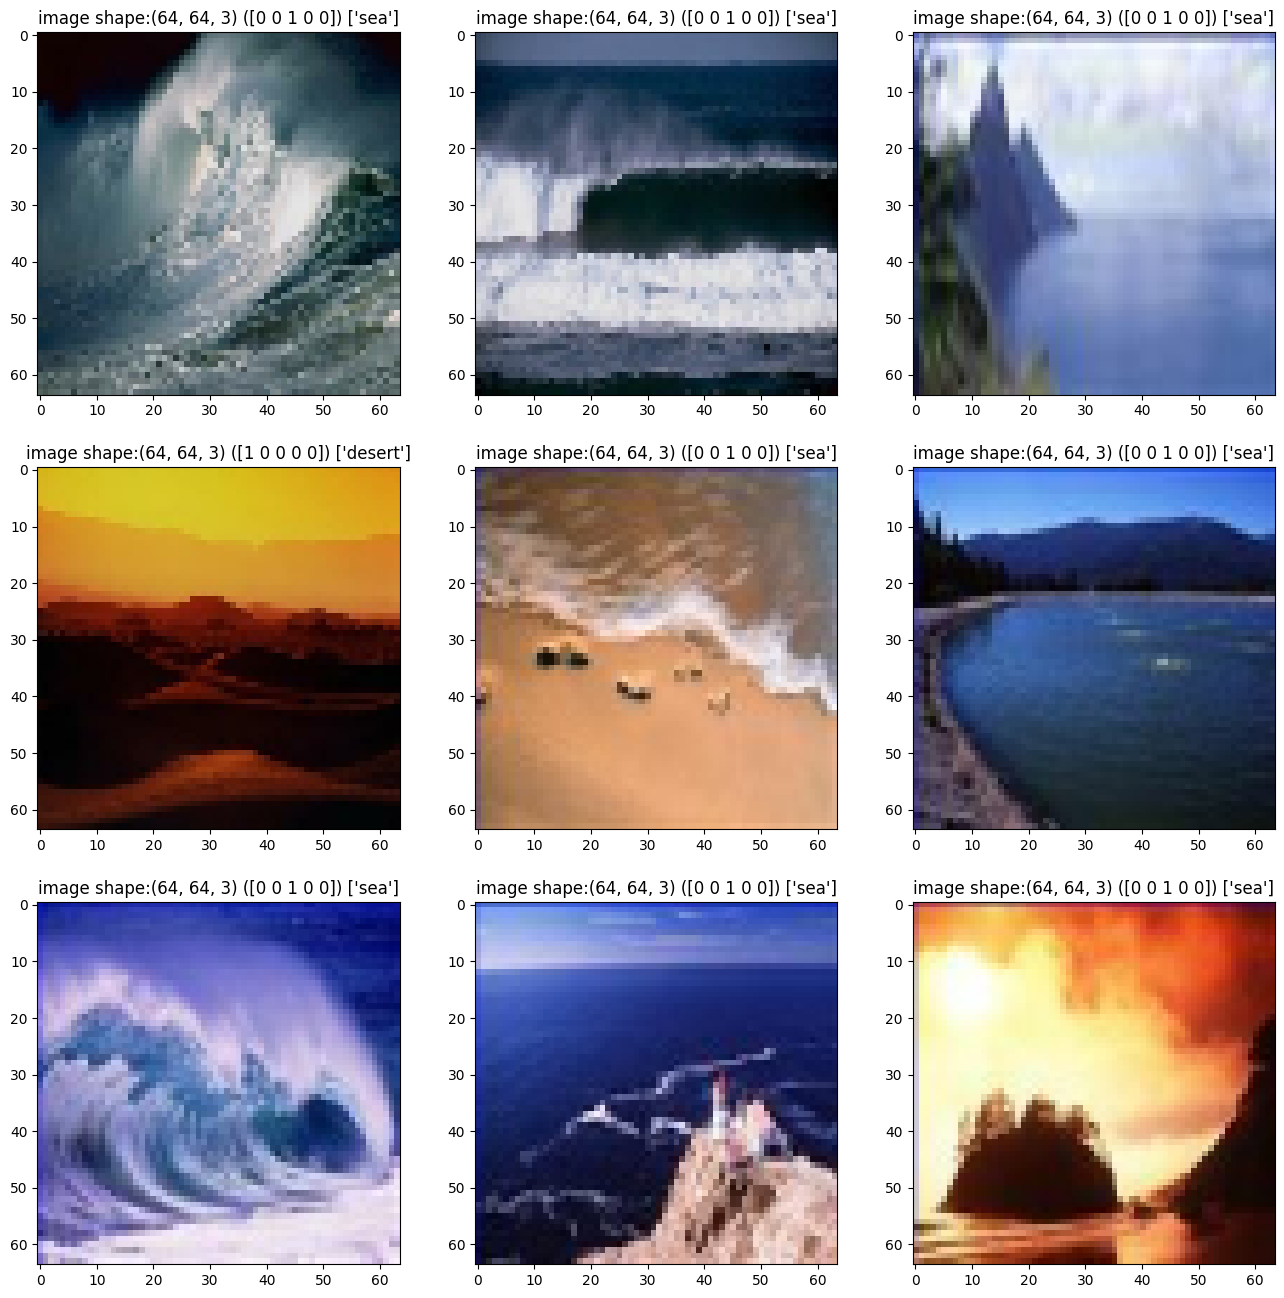

In [ ]:
def show_samples(dataset):
  fig=plt.figure(figsize=(16, 16))
  columns = 3
  rows = 3
  print(columns*rows,"samples from the dataset")
  i=1
  for a,b in dataset.take(columns*rows): 
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(a))
    plt.title("image shape:"+ str(a.shape)+" ("+str(b.numpy()) +") "+ 
              str(covert_onehot_string_labels(LABELS,b.numpy())))
    i=i+1
  plt.show()
show_samples(ds_test)

Prepare the data pipeline by setting batch size & buffer size using [tf.data](https://www.tensorflow.org/guide/data)

In [ ]:
ds_train_batched=ds_train.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE) 
ds_test_batched=ds_test.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)

print("Number of batches in train: ", ds_train_batched.cardinality().numpy())
print("Number of batches in test: ", ds_test_batched.cardinality().numpy())


Number of batches in train:  25
Number of batches in test:  7


Create a Keras CNN model 

Use Transfer Learning by importing VGG16

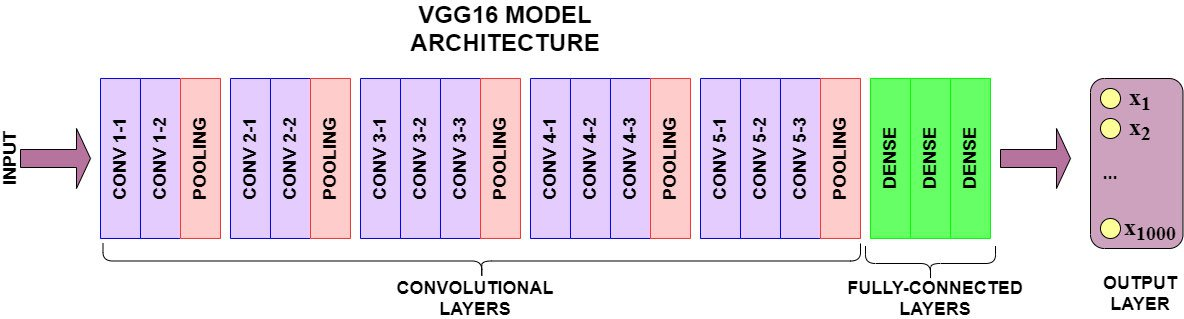

The 16 in VGG16 refers to 16 layers that have weights. In VGG16 there are thirteen convolutional layers , five Max Pooling layers, and three Dense layers which sum up to 21 layers but it has only sixteen weight layers i.e., learnable parameters layer

Input layer: The input size is typically 64x64x3, representing an RGB image with a height and width of 64 pixels each.

Convolutional layer 1: This layer has 64 filters, with a filter size of 3x3 and a stride of 1. The padding is "same", which means that the output feature maps have the same spatial dimensions as the input.

Convolutional layer 2: This layer also has 64 filters, with a filter size of 3x3 and a stride of 1. The padding is "same".

Avg pooling layer 1: This layer has a pool size of 2x2 and a stride of 2. It downsamples the feature maps by a factor of 2.

Convolutional layer 3: This layer has 128 filters, with a filter size of 3x3 and a stride of 1. The padding is "same".

Convolutional layer 4: This layer also has 128 filters, with a filter size of 3x3 and a stride of 1. The padding is "same".

Avg pooling layer 2: This layer has a pool size of 2x2 and a stride of 2. It downsamples the feature maps by a factor of 2.

Convolutional layer 5: This layer has 256 filters, with a filter size of 3x3 and a stride of 1. The padding is "same".

Convolutional layer 6: This layer also has 256 filters, with a filter size of 3x3 and a stride of 1. The padding is "same".

Convolutional layer 7: This layer also has 256 filters, with a filter size of 3x3 and a stride of 1. The padding is "same".

Avg pooling layer 3: This layer has a pool size of 2x2 and a stride of 2. It downsamples the feature maps by a factor of 2.

Convolutional layer 8: This layer has 512 filters, with a filter size of 3x3 and a stride of 1. The padding is "same".

Convolutional layer 9: This layer also has 512 filters, with a filter size of 3x3 and a stride of 1. The padding is "same".

Convolutional layer 10: This layer also has 512 filters, with a filter size of 3x3 and a stride of 1. The padding is "same".

Avg pooling layer 4: This layer has a pool size of 2x2 and a stride of 2. It downsamples the feature maps by a factor of 2.

Convolutional layer 11: This layer has 512 filters, with a filter size of 3x3 and a stride of 1. The padding is "same".

Convolutional layer 12: This layer also has 512 filters, with a filter size of 3x3 and a stride of 1. The padding is "same".

Convolutional layer 13: This layer also has 512 filters, with a filter size of 3x3 and a stride of 1. The padding is "same".

Avg pooling layer 5: This layer has a pool size of 2x2 and a stride of 2. It downsamples the feature maps by a factor of 2

Fully connected layer 1: This layer has 4096 neurons and takes as input the flattened output of the final avg pooling layer. The neurons are fully connected, meaning that each neuron in the layer is connected to every neuron in the previous layer.

Fully connected layer 2: This layer is identical to the first fully connected layer, with 4096 neurons.

Fully connected layer 3: This layer has 1000 neurons and serves as the output layer of the network. The number of neurons corresponds to the number of possible classes in the classification task. The neurons are fully connected to the previous layer, and the output of the layer is fed into a softmax activation function. The softmax function converts the output of each neuron into a probability distribution over the possible classes, such that the probabilities of all classes sum to 1.

In [ ]:
base_model = keras.applications.VGG16(
    weights='imagenet',  
    input_shape=(64, 64, 3), 
    include_top=False)  
base_model.trainable = False

58889256/58889256 [==============================] - 1s 0us/step


## 3.Fine-Tuning Module


In [ ]:
number_of_classes = 5

In [ ]:
inputs = keras.Input(shape=(64, 64, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
initializer = tf.keras.initializers.GlorotUniform(seed=42)

activation =  tf.keras.activations.sigmoid 

outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(x) 
model = keras.Model(inputs, outputs)

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                                 
Total params: 14,717,253
Trainable params: 2,565
Non-trainable params: 14,714,688
_________________________________________________________________


D/B between average and maximum pooling layer


The global average pooling layer takes the average of each feature map then sends the average value to the activation layer. 
The global max-pooling layer takes the maximum of each feature map and sends it directly to the activation layer in a fully connected layer. 


GlorotUniform(seed=42) -  Xavier uniform initializer - weight initialization technique


*   initialize the random number generator - multiple executions of the code on the same machine or on different machines
*   GlorotUniform initialization method with a random seed of 42, which ensures that the same set of weights will be initialized each time the model is trained
*   GlorotUniform initializer can be used by specifying it in the kernel_initializer or bias_initializer argument of a layer.



Activation Function
* The last layer has ***number_of_classes*** units. So the output (***y_pred***)  will be **a vector with number_of_classes dimension**.


* For the last layer, the activation function can be:
  * None 
  * sigmoid 
  * softmax



# 4. Training Module


Performance of the model by using **combination of activation  and loss functions.**


In [ ]:
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC, TruePositives, FalsePositives, FalseNegatives, TrueNegatives


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(), 
               metrics=[BinaryAccuracy(), Precision(), Recall(), AUC(), TruePositives(), FalsePositives(), FalseNegatives(), TrueNegatives()])          

Algorithm optimization - Adam (Adaptive Moment Estimation)

Adam uses a learning rate of 0.001

1.   Adagrad - The learning rate is adapted component-wise to the parameters by incorporating knowledge of past observations.
2.   Root Mean Squared Propagation(RMSProp) - restricts the oscillations in the vertical direction



What happens if we increase the epochs? 

Image result for increase an epoch will result in accuracy The number of epoch will decide- how many times we will change the weights of the network. As the number of epochs increases, the same number of times weights are changed in the neural network and the boundary goes from underfitting to optimal to overfitting.


In [ ]:
history=model.fit(ds_train_batched, validation_data=ds_test_batched, epochs=100)

Epoch 1/200
25/25 [==============================] - 1053s 42s/step - loss: 0.6870 - binary_accuracy: 0.6091 - precision: 0.1829 - recall: 0.1664 - auc: 0.4013 - true_positives: 330.0000 - false_positives: 1474.0000 - false_negatives: 1653.0000 - true_negatives: 4543.0000 - val_loss: 0.5767 - val_binary_accuracy: 0.7550 - val_precision: 0.3333 - val_recall: 0.0020 - val_auc: 0.4898 - val_true_positives: 1.0000 - val_false_positives: 2.0000 - val_false_negatives: 488.0000 - val_true_negatives: 1509.0000
Epoch 2/200
25/25 [==============================] - 105s 4s/step - loss: 0.5550 - binary_accuracy: 0.7523 - precision: 0.5556 - recall: 0.0025 - auc: 0.5813 - true_positives: 5.0000 - false_positives: 4.0000 - false_negatives: 1978.0000 - true_negatives: 6013.0000 - val_loss: 0.5938 - val_binary_accuracy: 0.7555 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3975 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_false_negatives: 489.0000 - val_t

In [ ]:
model.save('datamodel.h5')

In [ ]:
ds= ds_test_batched
print("Test Accuracy: ", model.evaluate(ds)[1])

In [ ]:
ds= ds_test_batched
print("Loss: ", model.evaluate(ds)[0])

# 5. Validation Module

JUSTIFICATION - ACCURACY

1.BINARY ACCURACY

Calculates the number of correctly predicted labels (i.e., samples where the predicted probability is greater than a threshold and the true label is 1, or where the predicted probability is less than the threshold and the true label is 0) divided by the total number of samples.



In [ ]:
y_pred_logit = tf.constant([[-20, -10.0, -44.5, -12.5, -74]], dtype = tf.float32)
print("y_pred_logit:\n", y_pred_logit.numpy())

y_pred_sigmoid = tf.keras.activations.sigmoid(y_pred_logit)

y_true=[[1, 0, 0, 0, 1]]
y_pred = y_pred_sigmoid
print("\ny_true {} \n\ny_pred by sigmoid {}\n".format(y_true, y_pred))
print("binary_accuracy: ", tf.keras.metrics.binary_accuracy
      (y_true, y_pred).numpy())
      

**IMPORTANT:** We need to use **keras.metrics.BinaryAccuracy()** for **measuring** the **accuracy** since it calculates how often predictions matches **multi labels**. 

In **multi-label** classification and true lables are encoded **multi-hot**, we need to compare ***pairwise (binary!)***:  each element of prediction with the corresponding element of true lables. 

However, if you insist on using binary_crossentropy change your metric to metrics=['binary_accuracy', 'categorical_accuracy'] (this will display both accuracies).




GRAPH - PERFORMANCE METRICS

2.BINARY ACCURACY & LOSS ACCURACY

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

3.PRECISION & RECALL CURVE

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

In [ ]:


y_true = [1, 0, 0, 0, 1]
y_scores = [-20, -10.0, -44.5, -12.5, -74]

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

4.ROC - AUC CURVE

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_true = [1, 0, 0, 0, 1]
y_scores = [0.1, 0.5, 0.8, 0.3, 0.9]

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## 6. INFERENCE MODULE - sample prediction

In [ ]:
ds=ds_test
predictions= model.predict(ds.batch(batch_size=10).take(1))
print("A sample output from the last layer (model) ", predictions[0])
y=[]
print("10 Sample predictions:")
for (pred,(a,b)) in zip(predictions,ds.take(10)):
  
  pred[pred>0.5]=1
  pred[pred<=0.5]=0
  print("predicted: " ,pred, str(covert_onehot_string_labels(LABELS, pred)),  
        "Actual Label: ("+str(covert_onehot_string_labels(LABELS,b.numpy())) +")")
  y.append(b.numpy())

## 7.Post-processing Module

Observations

1.SparseCategoricalCrossentropy loss function + Sigmoid / Softmax / No activation function




To **encode** the true labels, we are using **multi-hot vectors**. 

*   However, SparseCategoricalCrossentropy expects the true labels as an **integer** number.
*   Moreover, we **can NOT encode** multi-labels as an integer since there would be more than one label for a sample. 

*   Therefore, the SparseCategoricalCrossentropy loss functions can ***NOT handle multi-hot vector!***






  


2.Softmax activation function + BinaryCrossentropy loss function

When **softmax** is applied as the last layer's **activation** function, is is able to ***only select a single label as the prediction*** as softmax normalizes all predicted values as a probability distribution. Only one label could get higer value than 0.5. 

  Thus, **softmax can only predict a SINGLE class at most!** in a multi-label problem! So softmax will ***miss other true labels*** which leads **inferiror** performance compared to **sigmoid**.

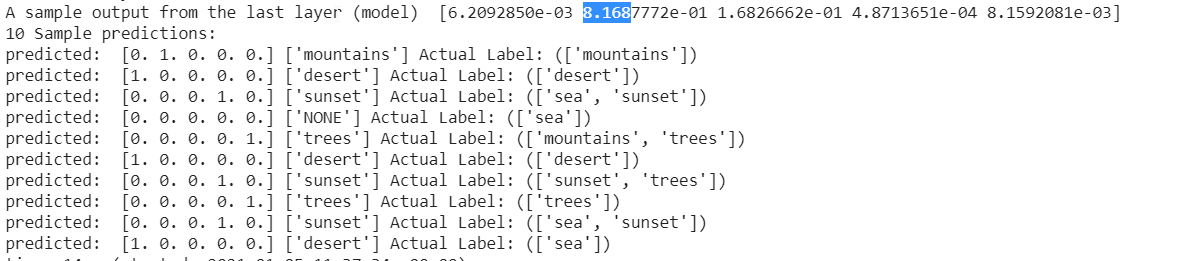

3.Sigmoid activation function + BinaryCrossentropy loss function

When **sigmoid** is applied as the last layer's activation function, it is able to ***select multiple labels as the prediction*** as sigmoid normalize each predicted logit values between 0 and 1 independently

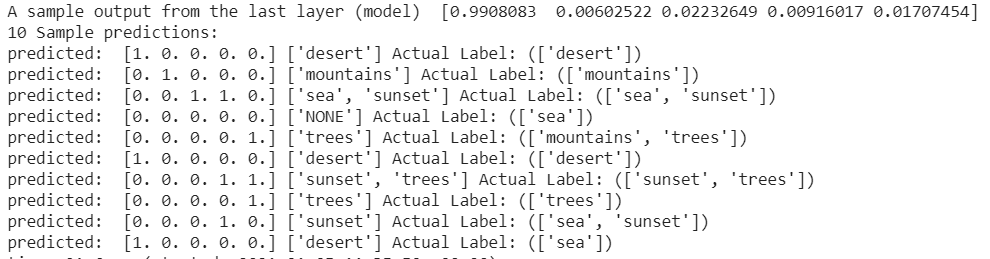

4.No activation function + BinaryCrossentropy loss function



When no activation function (**None**) is used, each label prediction gets arbitrary numbers from negative infinitive to positive infinitive. BinaryCrossentropy with `from_logits` parameter is set `True` automatically applies sigmoid on these logits. Thus, in this case, we have a similar performance compared to the case where we use sigmoid for the last layer's activation function. 

If your output layer has a 'softmax' activation, from_logits should be False. If your output layer doesn't have a 'softmax' activation, from_logits should be True.

5.Softmax activation function + CategoricalCrossentropy loss function

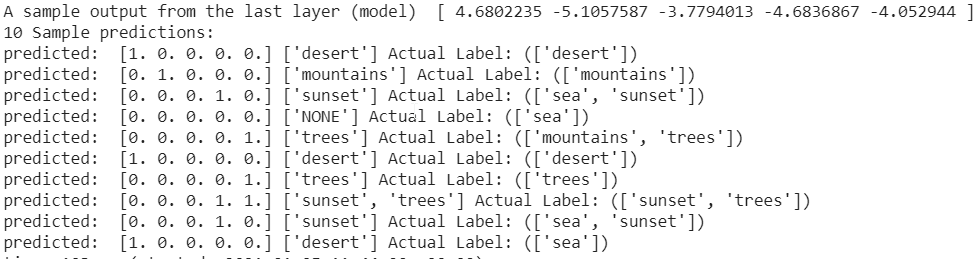

When **softmax** is applied as the last layer's activation function, we can ***only select a single label as the prediction*** as softmax normalize all predicted values as a probability distribution. Only one label could get higer value than 0.5



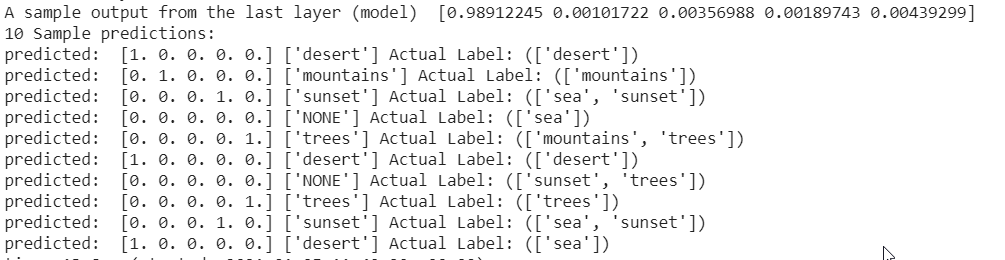

6.Sigmoid activation function + CategoricalCrossentropy loss function

When **sigmoid** is the activation function & loss is computed by CategoricalCrossentropy function, we ***can NOT select any labels as the prediction*** because all the predicted values get very close to zero.



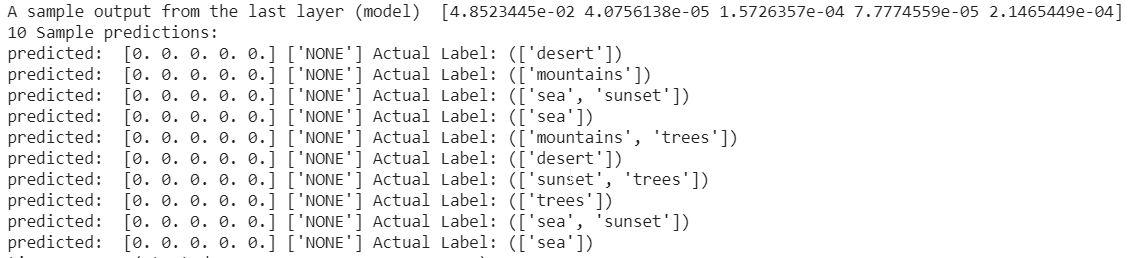

7.No activation function + CategoricalCrossentropy loss function

* When there is **no activation** function is used in the model's last layer, we need to set `from_logits=True` **in cross-entropy loss functions** . Thus, **cross-entropy loss functions** will apply a **sigmoid** transformation on **predicted label values** by itself:

* When **None** of the activation functions is selected & loss is computed by 
CategoricalCrossentropy function, each label prediction gets arbitrary numbers from negative infinitive to positive infinitive. All predicted label values get higher than 0.5. Thus, **all labels are selected**.






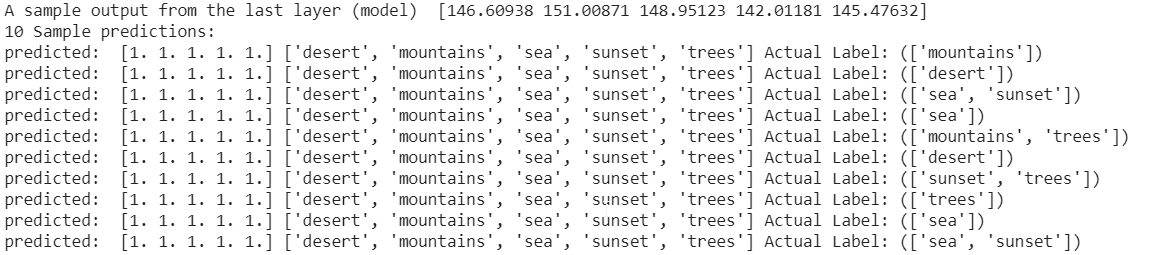

8.Categorical crossentropy vs binary crossentropy

In multi-label classification, the Categorical_Crossentropy loss function treats each label as an independent binary classification problem and calculates the loss separately for each one. This can lead to suboptimal performance in cases where the relationship between the labels is important to capture.
Binary_Crossentropy, which can be applied to each label independently and then combined.

Obtained Results:





| Activation | Loss | Accuracy |
| :- | -: | :-: |
| softmax | BinaryCrossentropy() |0.8675
| **sigmoid** | **BinaryCrossentropy()** |**0.9020**
| None | BinaryCrossentropy(from_logits=True) | 0.8705
| softmax  |  CategoricalCrossentropy() |0.8665
| sigmoid |  CategoricalCrossentropy() | 0.7460
| None |  CategoricalCrossentropy(from_logits=True) | 0.2540
| softmax | SparseCategoricalCrossentropy() |InvalidArgumentError:  labels must be 1-D, but got shape [64,5]
| sigmoid | SparseCategoricalCrossentropy() | InvalidArgumentError:  labels must be 1-D, but got shape [64,5]
| None | SparseCategoricalCrossentropy(from_logits=True) |InvalidArgumentError:  labels must be 1-D, but got shape [64,5]






## FINAL SUMMARY OUTPUT

In [ ]:
print("Summary Report: ", model.summary())

According to the above experiment results, if the task is **multi-label classification**, we need to set-up:

* true (actual) labels encoding = **multi-hot vector**

* activation = **sigmoid**

* loss = **BinaryCrossentropy()**

* accuracy metric= **BinaryAccuracy()**







## JUSTIFICATION - REDUCE TIME COMPLEXITIES

Low complexity encoder:
             Use of low complexity encoder in the input layer to resize and scale the images so that we can save time in training, testing, fitting data models.

Parallel processing:
            The value tf.data.AUTOTUNE means that TensorFlow will dynamically adjust the number of parallel calls to maximize the performance which includes in reducing time complexity to get desired outcome 

Data sampling:
           If the dataset is very large, you can use random sampling techniques to reduce the size of the data, and hence, the time complexity of the classification process.

Early Stopping: 
           By monitoring the performance of the classifier on a validation set and stopping the training process once the performance reaches a satisfactory level, the time complexity can be reduced.


## REFERENCES

[ Keras API reference / Losses / Probabilistic losses](https://keras.io/api/losses/probabilistic_losses/
) 

[Keras API reference / Layers API / Layer activation functions](https://keras.io/api/layers/activations/)

[Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data#using_tfdata_with_tfkeras)

[TensorFlow - SparseCategoricalCrossentropy](https://stackoverflow.com/questions/59787897/how-does-tensorflow-sparsecategoricalcrossentropy-work)


[Cross-entropy vs sparse-cross-entropy](https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other)

[Binary_crossentropy and categorical_crossentropy - different performance](https://stackoverflow.com/questions/42081257/why-binary-crossentropy-and-categorical-crossentropy-give-different-performances)